In [2]:
import jax.numpy as np
import numpy
import itertools
from jax import grad, jit, vmap
from jax import random
from jax.experimental import optimizers
import matplotlib.pyplot as plt

In [3]:
def random_layer_params(indim, outdim, key, scale=1e-2):
  w_key, b_key = random.split(key)
  return scale * random.normal(w_key, (outdim, indim)), scale * random.normal(b_key, (outdim,))

def init_network_params(sizes, key):
  keys = random.split(key, len(sizes))
  return [random_layer_params(m, n, k) for m, n, k in zip(sizes[:-1], sizes[1:], keys)]

In [4]:
def generateTrajectory_HO(delta_t, nsteps, ndata, noise_scale):
    amplitude = random.normal(key=random.PRNGKey(0), shape=(ndata, 1)) * 5
    amplitude = np.tile(amplitude, (1, nsteps))
    nT0 = random.normal(key=random.PRNGKey(1), shape=(ndata, 1)) * np.pi * 2
    nT0 = np.tile(nT0, (1, nsteps))
    ts = np.reshape(np.arange(nsteps), (1, nsteps)) * delta_t
    ts = np.tile(ts, (ndata, 1))
    qs = amplitude * np.sin(ts) + noise_scale * random.normal(key=random.PRNGKey(2), shape=ts.shape)
    ps = amplitude * np.cos(ts) + noise_scale * random.normal(key=random.PRNGKey(3), shape=ts.shape)
    q_dots = (qs[1:] - qs[:-1]) / delta_t
    p_dots = (ps[1:] - ps[:-1]) / delta_t
    
    return np.stack((qs, ps), axis=2), np.stack((q_dots, p_dots), axis=2)

In [5]:
def Hamiltonian(qp, ws):
    for W, b in ws:
        out = np.dot(W, qp) + b
        qp = np.tanh(out)
    return np.sum(out)

dH = grad(Hamiltonian)
t_dH = vmap(dH, (0, None), 0)
bt_dH = vmap(t_dH, (0, None), 0)

# qp: trajectory [t x 2]
def loss(ws, qp, delta_t):
    qp_dots = (qp[:, 1:, :] - qp[:, :-1, :]) / delta_t
    dHs = bt_dH(qp, ws)
    return np.sum((qp_dots[:, :, 0] - dHs[:, :-1, 1])**2 + (qp_dots[:, :, 1] + dHs[:, :-1, 0])**2) / len(qp)

def update(i, opt_state, qp, delta_t, lr):
    grads = grad(loss)(get_params(opt_state), qp, delta_t)    
    return opt_update(i, grads, opt_state)

In [6]:
# Parameters
layer_sizes = [2, 64, 32, 1]
delta_t = 0.1
nsteps = 30
ndata = 300
noise_scale = 0.00
nepoch = 200
bs = 16
lr = 5e-3

epoch:1 loss = 414.8084
epoch:2 loss = 778.14246
epoch:3 loss = 772.1428
epoch:4 loss = 806.6446
epoch:5 loss = 663.9346
epoch:6 loss = 568.17145
epoch:7 loss = 315.63217
epoch:8 loss = 750.1058
epoch:9 loss = 584.73486
epoch:10 loss = 511.97723
epoch:11 loss = 389.16663
epoch:12 loss = 204.75703
epoch:13 loss = 273.1707
epoch:14 loss = 343.4001
epoch:15 loss = 362.04187
epoch:16 loss = 329.8637
epoch:17 loss = 131.36293
epoch:18 loss = 61.31228
epoch:19 loss = 256.5876
epoch:20 loss = 719.21106
epoch:21 loss = 73.136795
epoch:22 loss = 284.73926
epoch:23 loss = 91.97288
epoch:24 loss = 316.2484
epoch:25 loss = 215.53854
epoch:26 loss = 528.9696
epoch:27 loss = 15.566961
epoch:28 loss = 511.32233
epoch:29 loss = 32.920597
epoch:30 loss = 761.5151
epoch:31 loss = 8.025792
epoch:32 loss = 288.39072
epoch:33 loss = 433.4161
epoch:34 loss = 28.431171
epoch:35 loss = 13.377674
epoch:36 loss = 76.150696
epoch:37 loss = 26.376207
epoch:38 loss = 278.6637
epoch:39 loss = 13.9082575
epoch:40 lo

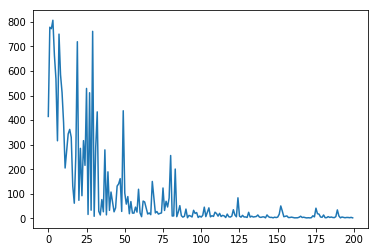

In [7]:
# Data
qps, qp_dots = generateTrajectory_HO(delta_t, nsteps, ndata, noise_scale)
# Init
ws = init_network_params(layer_sizes, random.PRNGKey(0))
opt_init, opt_update, get_params = optimizers.adam(lr)
opt_state = opt_init(ws)
itercount = itertools.count()
# Learn
losses = np.array([])
for epoch in range(nepoch):
    inds = numpy.random.permutation(ndata)
    for i in range(int(nepoch / bs)):
        qp_batch = qps[inds[i * bs:(i+1) * bs], :, :]
        opt_state = update(next(itercount), opt_state, qp_batch, delta_t, lr)
    l = loss(get_params(opt_state), qp_batch, delta_t)
    losses = np.append(losses, l)
    print('epoch:' + str(epoch + 1) + ' loss = ' + str(loss(get_params(opt_state), qp_batch, delta_t)))

plt.plot(losses)


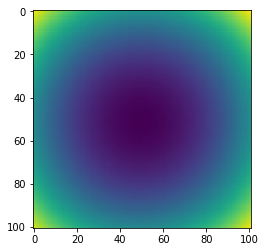

In [9]:
q_grid, p_grid = np.meshgrid(np.linspace(0,1,101) - 0.5, np.linspace(0,1,101) - 0.5)
grid_shape = q_grid.shape
q_grid = np.reshape(q_grid, (int(np.prod(q_grid.shape)))) * 5
p_grid = np.reshape(p_grid, (int(np.prod(p_grid.shape)))) * 5
qp_grid = np.stack((q_grid, p_grid))
qp_grid = np.transpose(qp_grid)

b_H = vmap(Hamiltonian, (0, None), 0)
H_grid = b_H(qp_grid, get_params(opt_state))
H_grid = np.reshape(H_grid, grid_shape)
plt.imshow(H_grid)

In [42]:
# Hamiltonian test
qp, qp_dot = generateTrajectory_HO(0.01, 10, 5, 1)
layer_sizes = [2, 32, 16, 1]
ws = init_network_params(layer_sizes, random.PRNGKey(0))
print(qp.shape)
tmp = np.dot(ws[0][0], qp[0,0,:])
print(tmp.shape)
tmp = np.dot(ws[1][0], tmp)
print(tmp.shape)
print(Hamiltonian(qp[0,0,:], ws))
print(dH)
print(t_dH(qp[0,:,:], ws))
print(bt_dH(qp, ws))
print(bt_dH(qp, ws).shape)

(5, 10, 2)
(32,)
(16,)
-0.004826009
<function grad.<locals>.grad_f at 0x7fd76c776950>
[[-2.1805317e-07  9.7214370e-06]
 [-2.2863787e-07  9.7248085e-06]
 [-2.2877975e-07  9.7253642e-06]
 [-2.1655251e-07  9.7174088e-06]
 [-2.3127541e-07  9.7240209e-06]
 [-2.1911728e-07  9.7269140e-06]
 [-2.5048757e-07  9.7178745e-06]
 [-2.2355380e-07  9.7176217e-06]
 [-2.7147144e-07  9.7103566e-06]
 [-1.9991603e-07  9.6914773e-06]]
[[[-2.1805499e-07  9.7214333e-06]
  [-2.2864151e-07  9.7248085e-06]
  [-2.2877794e-07  9.7253596e-06]
  [-2.1655978e-07  9.7174106e-06]
  [-2.3126813e-07  9.7240281e-06]
  [-2.1911910e-07  9.7269130e-06]
  [-2.5048575e-07  9.7178763e-06]
  [-2.2355016e-07  9.7176217e-06]
  [-2.7147144e-07  9.7103557e-06]
  [-1.9991421e-07  9.6914773e-06]]

 [[-1.7037200e-07  9.6028980e-06]
  [-1.5736987e-07  9.5639953e-06]
  [-2.0355401e-07  9.6161493e-06]
  [-2.2893801e-07  9.5192463e-06]
  [-1.7566344e-07  9.5654395e-06]
  [-1.5448859e-07  9.5005435e-06]
  [-9.8429155e-08  9.4228544e-06]
  [

In [31]:
# loss test
print(qp.shape)
print(loss(ws, qp, delta_t))
#print(b_loss(ws, qp, delta_t))

(5, 10, 2)
290058.66


In [10]:
# Data test
qps, qp_dots = generateTrajectory_HO(delta_t, nsteps, ndata, noise_scale)

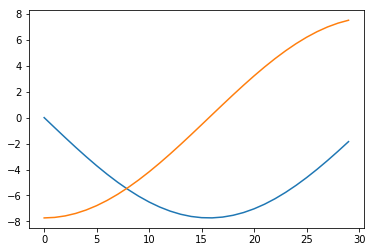

In [12]:
plt.plot(qps[0, :, 0])
plt.plot(qps[0, :, 1])
plt.show()